In [1]:
import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input, Subtract, add, Dot
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [4]:
def one_hot(Y):
    C = len(list(set(Y)))
    Y_OH = np.eye(C)[Y.reshape(-1)]

    return Y_OH

In [5]:
def evaluate_model(model, X_train, Y_train, X_test, Y_test, maxItem = 100):
    #test model on training data set and testing data set
    nTrain = min([maxItem, X_train.shape[0]])
    print('Performance on Training data set (%d)' % nTrain)
    preds = model.evaluate(X_train[0:nTrain], Y_train[0:nTrain])
    print ("Loss = " + str(preds[0]))
    print ("Train Accuracy = " + str(preds[1]))

    nTest = min([maxItem, X_test.shape[0]])
    print('Performance on Testing data set (%d)' % nTest)
    preds = model.evaluate(X_test[0:nTest], Y_test[0:nTest])
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

In [6]:
def load_FaceData(datapath =r'C:\\Users\\abdalah\\Face Recognition\\FaceNet\\Caltech\\Processed\\'):
    FaceData = []
    for iFace in range(nFace):
        im = misc.imread(datapath+'cf%04d.png' % iFace)
        im = misc.imresize(im,(96,96,3))
        im = np.around(np.transpose(im, (2,0,1))/255.0, decimals=12)
        #im = np.transpose(im,[2,0,1])
        FaceData.append(im)
    FaceData = np.array(FaceData)
    labels = np.load(datapath+'Labels.npy')
    labels_OH = one_hot(labels)
    return FaceData, labels,labels_OH

In [7]:
def face_dist(f1,f2,w=1):
    if w==1:
        w = np.ones(f1.shape)
    if len(f1.shape)==len(f2.shape)==1:
        dist = np.linalg.norm((f1-f2)*w)
    else:
        dist = np.linalg.norm((f1-f2)*w, axis=1)
    return dist

In [8]:
def distance_based_prediction(FaceEmbedding, Labels, f):
    
    Dists = face_dist(FaceEmbedding,f)
    
    i = np.argmin(Dists)
    
    return Labels[i]

In [15]:
from keras.models import model_from_json
def load_base_model():
    model = model_from_json(open(r'C:\Users\abdalah\Face Recognition\FaceNet\FaceNet_Model\FaceNet.json').read())
    model.load_weights(r'C:\Users\abdalah\Face Recognition\FaceNet\FaceNet_Model\FaceNet_weights.h5')
    return model

In [10]:
nFace = 450

In [11]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

#     anchorpositive, anchornegative = y_pred[0], y_pred[1]

#     ### START CODE HERE ### (≈ 4 lines)
#     # Step 1: Compute the (encoding) distance between the anchor and the positive
#     pos_dist = K.sum(K.square(anchorpositive),axis=-1)
#     # Step 2: Compute the (encoding) distance between the anchor and the negative
#     neg_dist = K.sum(K.square(anchornegative),axis=-1)
#     # Step 3: subtract the two previous distances and add alpha.
#     basic_loss = pos_dist - neg_dist + alpha
#     # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
#     loss = K.sum(K.maximum(basic_loss,0.0))
#     ### END CODE HERE ###

    loss = K.sum(K.maximum(y_pred+alpha,0.0))

    return loss


In [12]:
def VecDist(tensors):
    dist = K.sum(K.square(tensors[0]-tensors[1]),axis=-1)
    return dist

In [13]:
def Create_Siamese_model(basemodel,alpha = 0.2):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    Anchor_Input    = Input(basemodel_input_shape)
    Positive_Input  = Input(basemodel_input_shape)
    Negative_Input  = Input(basemodel_input_shape)
    
    Anchor_Predict   = basemodel(Anchor_Input)
    Positive_Predict = basemodel(Positive_Input)
    Negative_Predict = basemodel(Negative_Input)

    AP_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Positive_Predict])
    AN_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Negative_Predict])

    print(AP_dist,AN_dist)
    APN = Subtract()([AP_dist,AN_dist])
    print(APN)
                     
    SiameseModel = Model(inputs = [Anchor_Input, Positive_Input, Negative_Input], outputs = APN)
    
    return SiameseModel 

In [16]:
FNModel = load_base_model()

In [17]:
FNModel.count_params()

3743280

In [18]:
FaceData, labels, labels_OH = load_FaceData()
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)

C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(450, 3, 96, 96)
(450,)
(450, 31)


In [19]:
nPeople = labels_OH.shape[1]

In [20]:
%time FaceEmbedding = FNModel.predict(FaceData)

Wall time: 9.54 s


Text(0.5, 1.0, 'feature space')

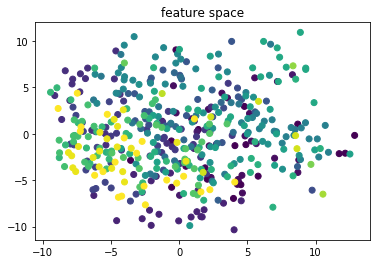

In [21]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

In [22]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Cross-class distance = 0.805 +\- 0.168
Same-class distance = 0.519 +\- 0.232


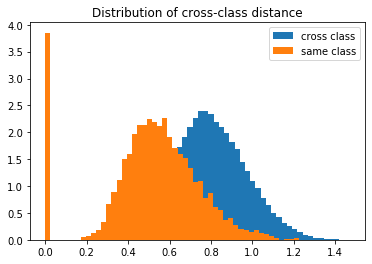

In [23]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

pct of false positive 23.812 %
pct of false negative 22.103 %
accuracy = 76.268


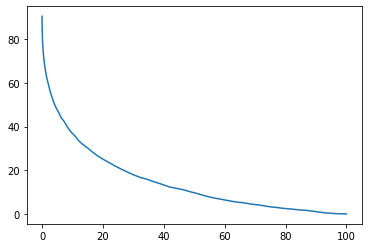

In [25]:
FP = []
FN = []

for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    
plt.plot(FP,FN)  
threshold = 0.68
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [26]:
train_idx = []
test_idx = []
for l in set(labels):
    ind = np.where(labels==l)[0]
    if len(ind)<=1:
        ind_train = list(ind)
        ind_test = []
    else:
        i_split = max([3,int(len(ind)*0.7)])
        ind_train = list(ind[0:i_split])
        ind_test = list(ind[i_split:])
    train_idx += ind_train
    test_idx += ind_test  
print("Training data set has %d face images", len(train_idx))
print("Test data set has %d face images", len(test_idx))

Training data set has %d face images 307
Test data set has %d face images 143


In [27]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 74.126 %


In [28]:
print(nCorrect)

106


In [29]:
SiameseModel = Create_Siamese_model(FNModel)

Tensor("lambda_1/Sum:0", shape=(None,), dtype=float32) Tensor("lambda_2_1/Sum:0", shape=(None,), dtype=float32)
Tensor("subtract_1/sub:0", shape=(None,), dtype=float32)


In [30]:
SiameseModel.output

<tf.Tensor 'subtract_1/sub:0' shape=(None,) dtype=float32>

In [31]:
SiameseModel.compile(optimizer = 'adam', loss = triplet_loss)

In [32]:
SiameseModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
FaceRecoModel (Model)           (None, 128)          3743280     input_1[0][0]                    
                                                                 input_2[0][0]              

In [33]:
nFace

450

In [34]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold = 0.4
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold).sum()
        nNegativeFaces = max(1,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

In [36]:
nAPN = len(A)
print('%d number of Anchors, Positives, Negatives APN combinations had been identified' % nAPN)

11794 number of Anchors, Positives, Negatives APN combinations had been identified


11794 number of A, P, N combinations had been identified


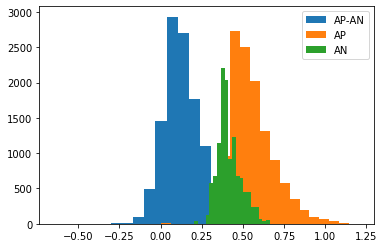

APN = 0.144 +\- 0.128
AP = 0.561 +\- 0.126
AN = 0.416 +\- 0.071


In [37]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [38]:
#SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 1, batch_size = 4)

Epoch 1/1
11794/11794 [==============================] - 2051s 174ms/step - loss: 0.0551


In [39]:
%time FaceEmbedding = FNModel.predict(FaceData)

Wall time: 11 s


In [40]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 80.420 %


In [41]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Cross-class distance = 1.009 +\- 0.389
Same-class distance = 0.281 +\- 0.264


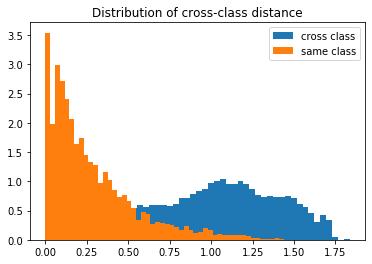

In [42]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

In [43]:
FNModel.save(r'C:\Users\abdalah\Face Recognition\FaceNet\FaceNet_Model\FaceNetModel_epoc1.h5')

In [44]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold_diff = 0.4
dist_threshold_same = 0.3
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold_diff).sum()
        nNegativeFaces = max(1,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold_same).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

57641 number of A, P, N combinations had been identified


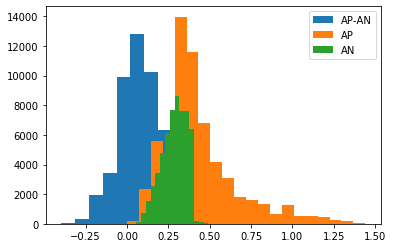

APN = 0.160 +\- 0.231
AP = 0.446 +\- 0.232
AN = 0.287 +\- 0.075


In [45]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [53]:
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 1, batch_size = 16)


MemoryError: 